In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.colors import ListedColormap

import torch


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import umap

path = "/media/DOCUMENTOS/Backups/Data"
    
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


def scale_array(dat, out_range=(-1, 1)):
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))

In [2]:
date="expo_SV0_march_14/"
path_coadds= path+ "/desi_data/"+date

In [3]:
df = pd.read_pickle(path_coadds+str(path_coadds.split("/")[-2])+".csv")
df.head()

TARGETID                                         WAVELENGTH  \
0  35186148770843363  [3600.0, 3600.7999999999997, 3601.6, 3602.4, 3...   
1  35186148770843761  [3600.0, 3600.7999999999997, 3601.6, 3602.4, 3...   
2  35186148770844616  [3600.0, 3600.7999999999997, 3601.6, 3602.4, 3...   
3  35186148775036873  [3600.0, 3600.7999999999997, 3601.6, 3602.4, 3...   
4  35186148775037106  [3600.0, 3600.7999999999997, 3601.6, 3602.4, 3...   

                                                FLUX  \
0  [11.763845, -9.042555, -1.1230043, 19.200214, ...   
1  [-0.9555723, 6.250731, -1.9111928, 9.312798, -...   
2  [4.726921, -3.0389764, 13.076285, 3.369187, 14...   
3  [-3.706038, 1.6860921, -10.580788, -9.966649, ...   
4  [-1.920743, 2.914958, 10.350556, 11.519347, 18...   

                                             ERRFLUX          CHI2         Z  \
0  [0.020826994, 0.012483846, 0.0119588915, 0.009...  10529.367356 -0.000112   
1  [0.024921758, 0.012632281, 0.012481794, 0.0114...   9007.644034  0.000073   
2  [0.02206422, 0.0123788435, 0.0110976305, 0.011...   7788.658614  0.000262   
3  [0.02543024, 0.012337107, 0.012181512, 0.01390...   8183.644792 -0.000182   
4  [0.024313116, 0.013164842, 0.010881489, 0.0113...   8432.237139 -0.000073   

       ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF    DELTACHI2  NUMEXP  \
0  0.000005      0     7754     STAR       M       5  7942.228051       0   
1  0.000007      0     7754     STAR       M       5  4972.447155       0   
2  0.000026      0     7752     STAR       K       5   226.806140       0   
3  0.000019      0     7756     STAR       K       5    82.897254       0   
4  0.000009      0     7757     STAR       K       5  1512.048298       0   

   NUMTILE   TILE      NIGHT PETAL  
0        0  65008  20200314.     0  
1        0  65008  20200314.     0  
2        0  65008  20200314.     0  
3        0  65008  20200314.     0  
4        0  65008  20200314.     0

In [4]:
columns_D = ['FLUX','TARGETID','TILE']
X = df[columns_D]
Y = np.array(df['SPECTYPE'])
wl = df['WAVELENGTH'][0]

In [5]:
classes = np.unique(Y)
print(classes)
for i, c in enumerate(classes):
    Y[Y == c] = i  # GALAXY=0  -   QSO=1    -  STAR=2
print(Y)

['GALAXY' 'QSO' 'STAR']
[2 2 2 ... 0 0 0]


In [6]:
TID1 = np.array(X['TARGETID']).tolist()
TILE1 = np.array(X['TILE']).tolist()
X1 = np.array(X['FLUX']).tolist()
Y1 = np.array(Y.tolist())


colors = np.zeros((len(Y1),4))
colors[:,0][Y1==0] = 0.45
colors[:,1][Y1==0] = 0.73
colors[:,2][Y1==0] = 1.0

colors[:,0][Y1==1] = 0.76
colors[:,1][Y1==1] = 0
colors[:,2][Y1==1] = 0.47

colors[:,0][Y1==2] = 0.58
colors[:,1][Y1==2] = 0.97
colors[:,2][Y1==2] = 0.48

Z = df['Z']
colors[:,3] = round(scale_array(Z,(0.4,1)),1)
colors

array([[0.58, 0.97, 0.48, 0.4 ],
       [0.58, 0.97, 0.48, 0.4 ],
       [0.58, 0.97, 0.48, 0.4 ],
       ...,
       [0.45, 0.73, 1.  , 0.4 ],
       [0.45, 0.73, 1.  , 0.5 ],
       [0.45, 0.73, 1.  , 0.5 ]])

In [7]:
train = torch.autograd.Variable(torch.Tensor(X1).float())
target = torch.autograd.Variable(torch.Tensor(Y1).long())

mean = train.mean(dim=0)
std = train.std(dim=0)
std[std==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean)/std
print(np.shape(train))
X = train.unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.99, random_state=42)
print(X_train[0].shape)


print(X_train.shape)

try:
    del df
except:
    print("Already delete")

torch.Size([25975, 7781])
torch.Size([1, 7781])
torch.Size([259, 1, 7781])


### Fisrt Configuration  1293

In [8]:

# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1, 50, kernel_size=9, stride=2),
            torch.nn.ReLU(True),
            torch.nn.Conv1d(50,10, kernel_size=5, stride=3),
            torch.nn.ReLU(True),
            torch.nn.Conv1d(10,4, kernel_size=3),
            torch.nn.ReLU(True))        
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose1d(4,10,kernel_size=3),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose1d(10,50,kernel_size=5, stride=3),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose1d(50,1,kernel_size=9, stride=2),
            torch.nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()

distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1E-3)

In [9]:
print(model.encoder(X_train)[0][2].detach().numpy().shape)

(1293,)


In [10]:
# entrenamiento
L = []
E = []
for epoch in range(num_epochs):
    output = model(X_train)
    loss = distance(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    E.append(epoch+1)
    L.append(loss.item())

epoch [1/100], loss:0.9447
epoch [2/100], loss:0.9443
epoch [3/100], loss:0.9442
epoch [4/100], loss:0.9442
epoch [5/100], loss:0.9442
epoch [6/100], loss:0.9442
epoch [7/100], loss:0.9442
epoch [8/100], loss:0.9442
epoch [9/100], loss:0.9442
epoch [10/100], loss:0.9442
epoch [11/100], loss:0.9442
epoch [12/100], loss:0.9442
epoch [13/100], loss:0.9442
epoch [14/100], loss:0.9442
epoch [15/100], loss:0.9442
epoch [16/100], loss:0.9442
epoch [17/100], loss:0.9442
epoch [18/100], loss:0.9442
epoch [19/100], loss:0.9442
epoch [20/100], loss:0.9442
epoch [21/100], loss:0.9442
epoch [22/100], loss:0.9442
epoch [23/100], loss:0.9442
epoch [24/100], loss:0.9442
epoch [25/100], loss:0.9442
epoch [26/100], loss:0.9442
epoch [27/100], loss:0.9442
epoch [28/100], loss:0.9442
epoch [29/100], loss:0.9442
epoch [30/100], loss:0.9442
epoch [31/100], loss:0.9442
epoch [32/100], loss:0.9442
epoch [33/100], loss:0.9442
epoch [34/100], loss:0.9442
epoch [35/100], loss:0.9442
epoch [36/100], loss:0.9442
e

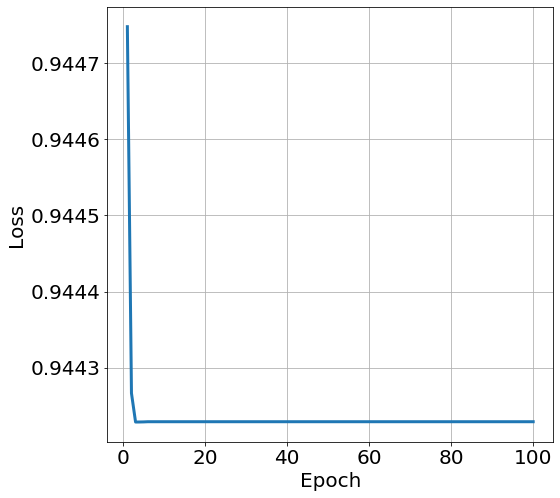

In [11]:
fig = plt.figure(figsize=(8,8))
plt.plot(E,L)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

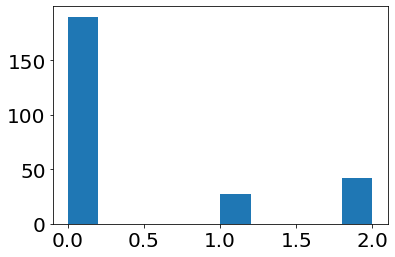

In [12]:
_ = plt.hist(y_train)

In [13]:
x_transform = model(X_train)
latent_space = model.encoder(X_train)

print(X_train.shape)
print(x_transform.shape)
print(latent_space.shape)

torch.Size([259, 1, 7781])
torch.Size([259, 1, 7781])
torch.Size([259, 4, 1293])


In [14]:
xt= x_transform.squeeze(1)
print(xt.shape)

torch.Size([259, 7781])


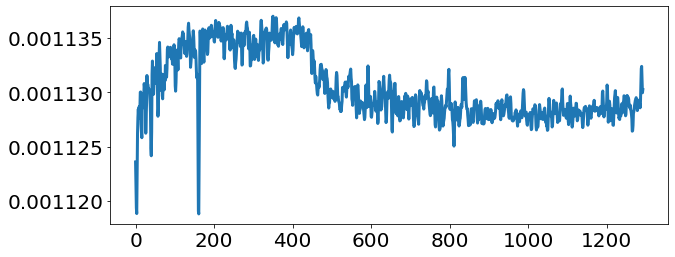

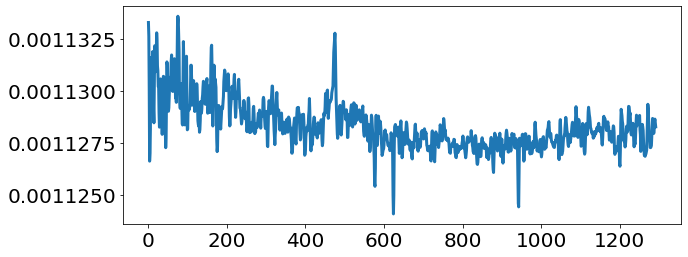

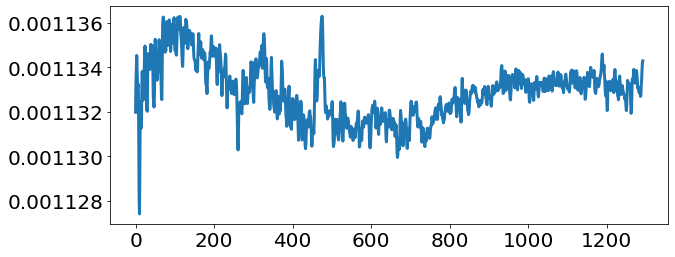

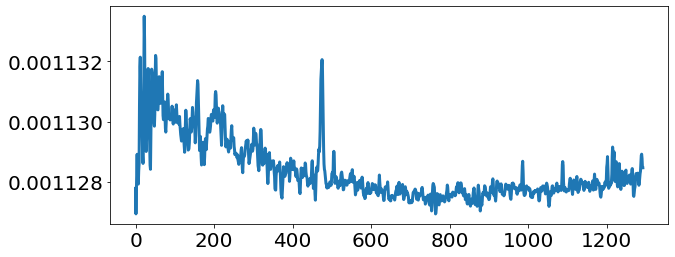

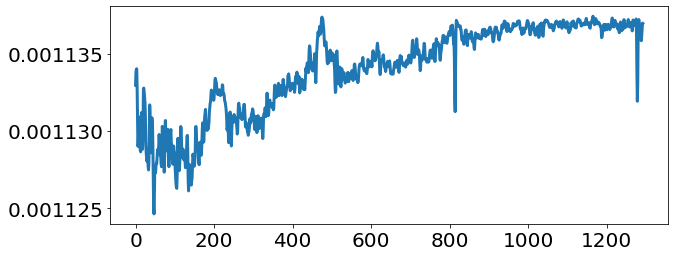

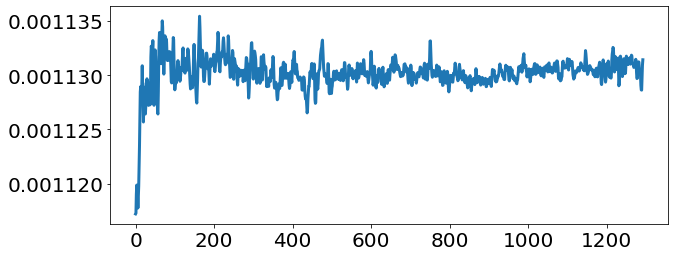

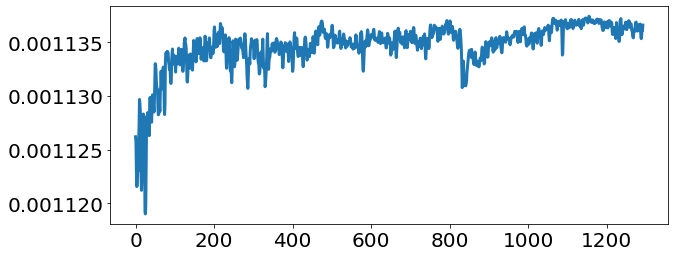

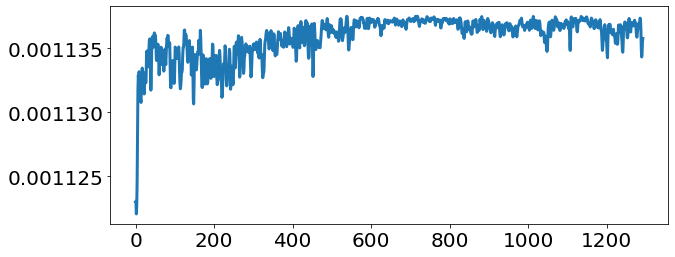

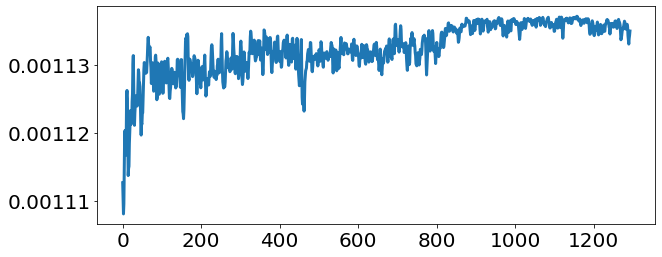

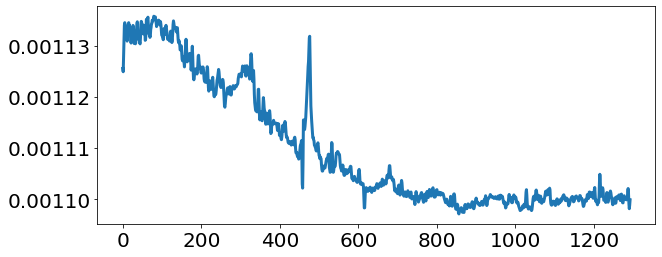

In [15]:
for i in range(10):
    fig = plt.figure(figsize=(10,4))
    plt.plot(latent_space[-i][0].detach().numpy())
    plt.show()

###  Second Configuration  384

In [16]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1, 50, kernel_size=11, stride=5),
            torch.nn.ReLU(True),
            torch.nn.Conv1d(50,10, kernel_size=7, stride=4),
            torch.nn.ReLU(True),
            torch.nn.Conv1d(10,4, kernel_size=5),
            torch.nn.ReLU(True))        
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose1d(4,10,kernel_size=5),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose1d(10,50,kernel_size=7, stride=4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose1d(50,1,kernel_size=11, stride=5),
            torch.nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()

distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1E-3)

In [17]:
print(model.encoder(X_train)[0][2].detach().numpy().shape)

(384,)


In [18]:
# entrenamiento
L = []
E = []
for epoch in range(num_epochs):
    output = model(X_train)
    loss = distance(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    E.append(epoch+1)
    L.append(loss.item())

epoch [1/100], loss:0.9442
epoch [2/100], loss:0.9442
epoch [3/100], loss:0.9442
epoch [4/100], loss:0.9442
epoch [5/100], loss:0.9442
epoch [6/100], loss:0.9442
epoch [7/100], loss:0.9442
epoch [8/100], loss:0.9442
epoch [9/100], loss:0.9442
epoch [10/100], loss:0.9442
epoch [11/100], loss:0.9442
epoch [12/100], loss:0.9442
epoch [13/100], loss:0.9442
epoch [14/100], loss:0.9442
epoch [15/100], loss:0.9442
epoch [16/100], loss:0.9442
epoch [17/100], loss:0.9442
epoch [18/100], loss:0.9440
epoch [19/100], loss:0.9434
epoch [20/100], loss:0.9430
epoch [21/100], loss:0.9428
epoch [22/100], loss:0.9430
epoch [23/100], loss:0.9431
epoch [24/100], loss:0.9429
epoch [25/100], loss:0.9425
epoch [26/100], loss:0.9415
epoch [27/100], loss:0.9367
epoch [28/100], loss:0.9142
epoch [29/100], loss:0.8396
epoch [30/100], loss:0.6406
epoch [31/100], loss:0.2689
epoch [32/100], loss:0.5495
epoch [33/100], loss:0.1986
epoch [34/100], loss:0.1839
epoch [35/100], loss:0.1447
epoch [36/100], loss:0.1345
e

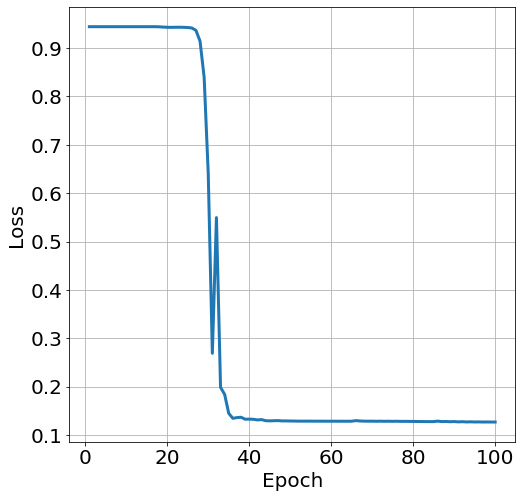

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(E,L)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [20]:
x_transform = model(X_train)
latent_space = model.encoder(X_train)

print(X_train.shape)
print(x_transform.shape)
print(latent_space.shape)

torch.Size([259, 1, 7781])
torch.Size([259, 1, 7781])
torch.Size([259, 4, 384])


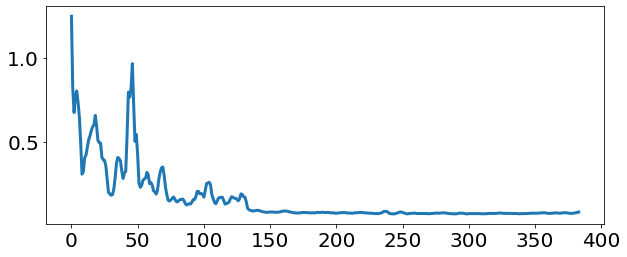

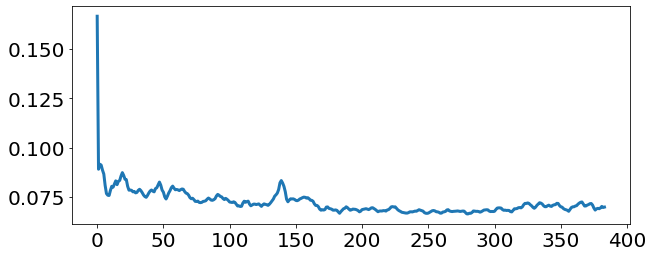

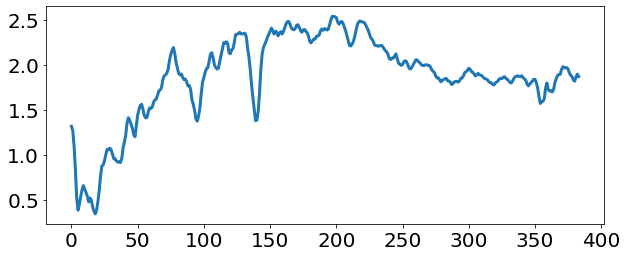

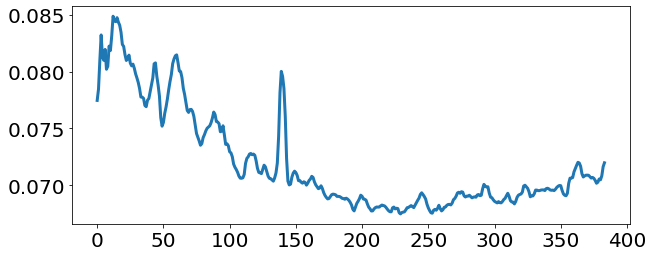

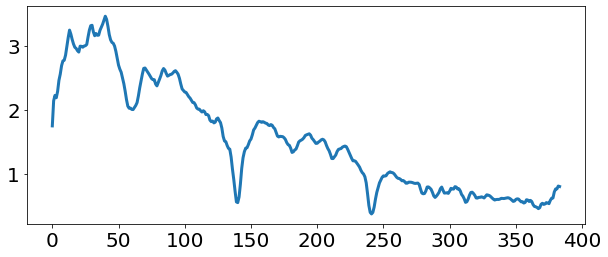

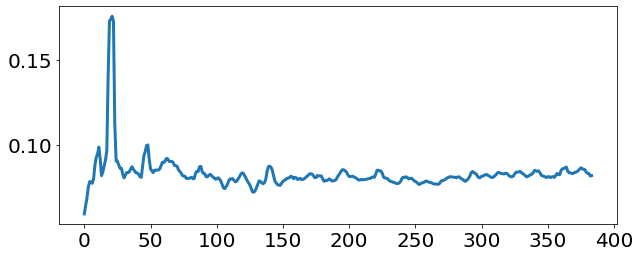

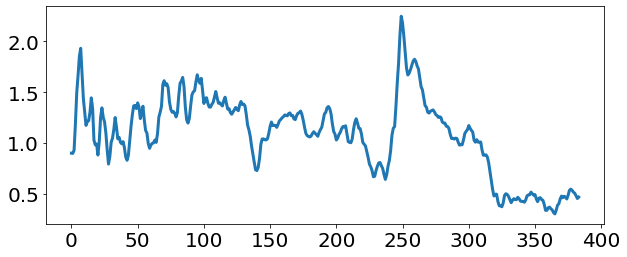

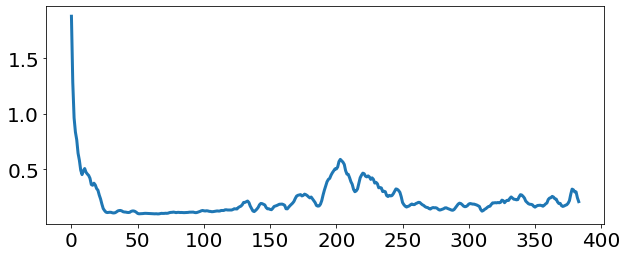

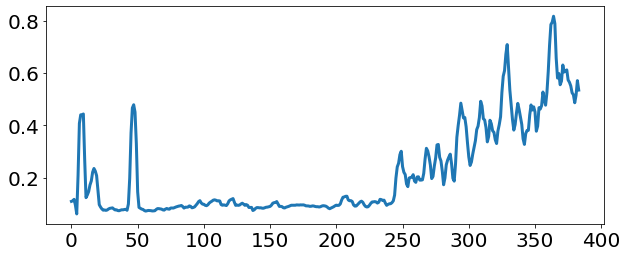

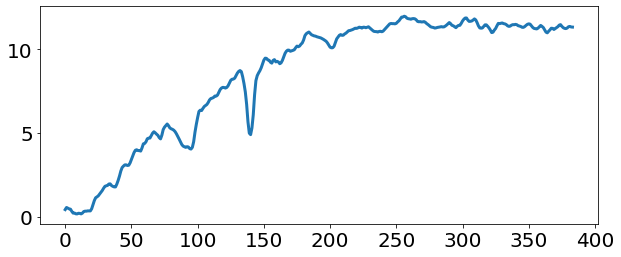

In [21]:
for i in range(10):
    fig = plt.figure(figsize=(10,4))
    plt.plot(latent_space[-i][0].detach().numpy())
    plt.show()

### Third Configuration  222

In [22]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1,50, kernel_size=11, stride=7),
            torch.nn.ReLU(True),
            torch.nn.Conv1d(50,10, kernel_size=6, stride=5),            
            torch.nn.ReLU(True))        
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose1d(10,50,kernel_size=6, stride=5),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose1d(50,1,kernel_size=11, stride=7),
            torch.nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()

distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1E-3)

In [23]:
print(model.encoder(X_train)[0][2].detach().numpy().shape)

(222,)


In [24]:
# entrenamiento
L = []
E = []
for epoch in range(num_epochs):
    output = model(X_train)
    loss = distance(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    E.append(epoch+1)
    L.append(loss.item())

epoch [1/100], loss:0.9442
epoch [2/100], loss:0.9251
epoch [3/100], loss:0.8166
epoch [4/100], loss:0.6537
epoch [5/100], loss:0.6722
epoch [6/100], loss:0.4964
epoch [7/100], loss:0.4133
epoch [8/100], loss:0.4017
epoch [9/100], loss:0.3861
epoch [10/100], loss:0.3675
epoch [11/100], loss:0.3369
epoch [12/100], loss:0.3105
epoch [13/100], loss:0.2912
epoch [14/100], loss:0.2747
epoch [15/100], loss:0.2655
epoch [16/100], loss:0.2591
epoch [17/100], loss:0.2535
epoch [18/100], loss:0.2507
epoch [19/100], loss:0.2473
epoch [20/100], loss:0.2452
epoch [21/100], loss:0.2439
epoch [22/100], loss:0.2428
epoch [23/100], loss:0.2432
epoch [24/100], loss:0.2434
epoch [25/100], loss:0.2427
epoch [26/100], loss:0.2434
epoch [27/100], loss:0.2415
epoch [28/100], loss:0.2419
epoch [29/100], loss:0.2413
epoch [30/100], loss:0.2407
epoch [31/100], loss:0.2405
epoch [32/100], loss:0.2400
epoch [33/100], loss:0.2399
epoch [34/100], loss:0.2398
epoch [35/100], loss:0.2375
epoch [36/100], loss:0.2305
e

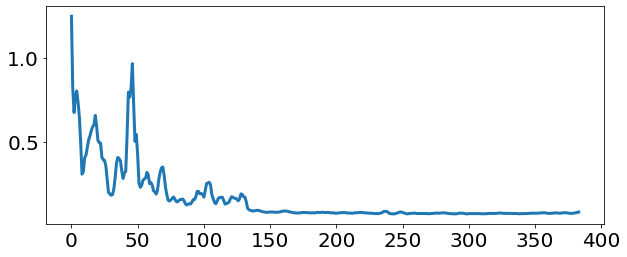

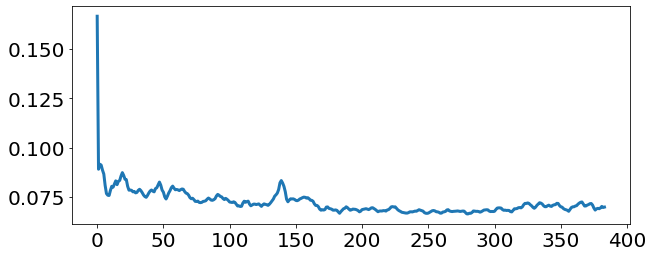

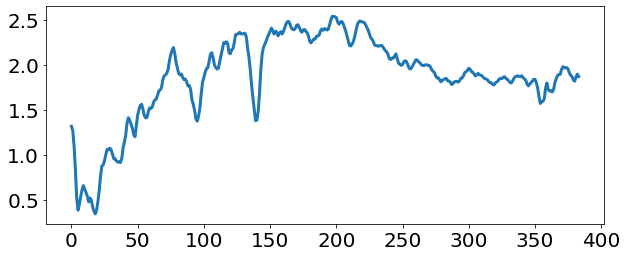

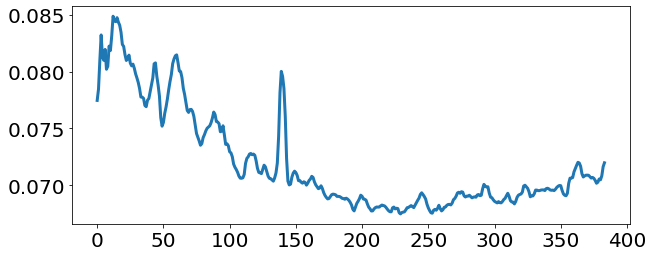

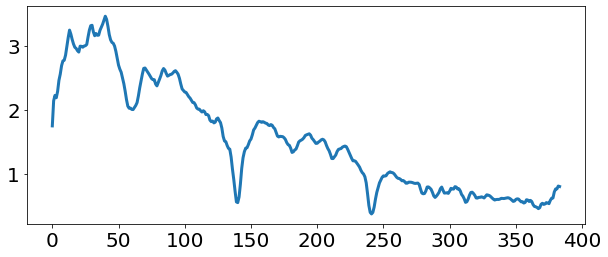

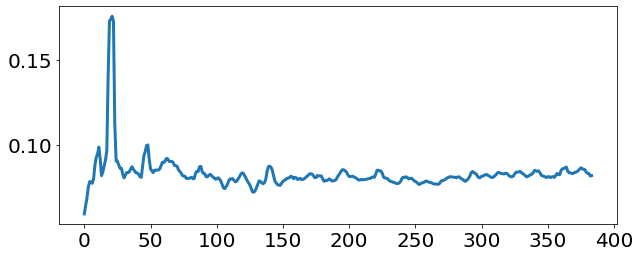

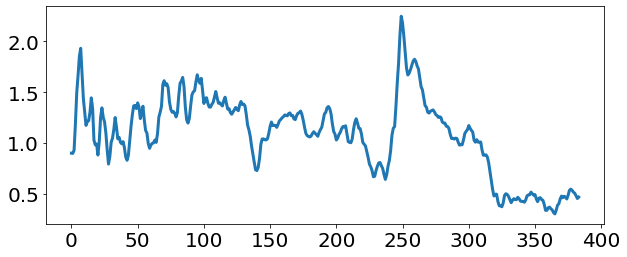

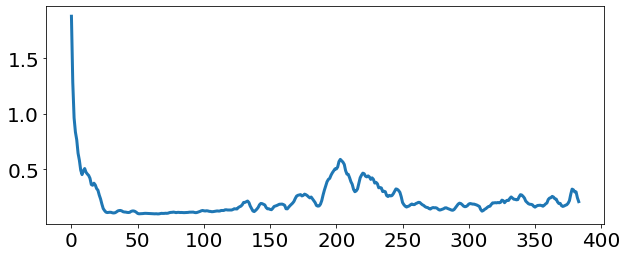

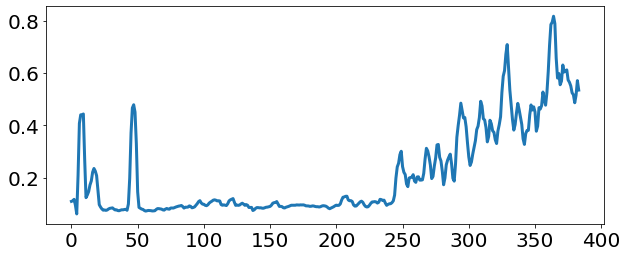

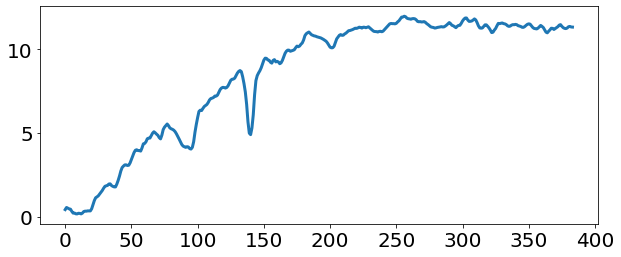

In [25]:
for i in range(10):
    fig = plt.figure(figsize=(10,4))
    plt.plot(latent_space[-i][0].detach().numpy())
    plt.show()